1) Анализ временных рядов помесячных продаж (с 2006 г.) б/у и новых автомобилей.
Построить ARIMA и ECM, показатели взять: общий уровень цен, курс валюты, ВВП (лучше не его), уровень доходов.
Лучше, если по регионам.

http://greenway.icnet.ru/cars-sales-actual-russia.html - useful material
https://www.autostat.ru/press-releases/47248/ - top 30 regions by ...

Рынок легковых автомобилей с пробегом в сентябре 2022 года
За дополнительной информацией обращайтесь в агентство «АВТОСТАТ» к Азату Тимерханову
по телефонам: +7 (8482) 95-64-36, +7 (499) 685-01-51, или по e-mail: press@autostat.ru

https://www.autostat.ru/research/product/322/ - RADAR

In [512]:
import pandas as pd

demand_df = pd.read_excel('data_time_series/demand_for_new_cars.xlsx')  # https://auto.vercity.ru/statistics/sales/europe/russia/

demand_df = pd.melt(demand_df, id_vars=['Year'])\
    .rename({'variable': 'Month', 'value': 'demand_new'}, axis=1)
demand_df['Month'] = pd.to_datetime(demand_df['Month'], format='%B').dt.month
demand_df['date'] = pd.to_datetime(demand_df[['Year', 'Month']].assign(DAY=1))
demand_df = demand_df[['date', 'demand_new']].sort_values(['date']).reset_index(drop=True)

# print(demand_df.tail(3))
demand_df = demand_df[:-1]

demand_df['demand_new'] = demand_df['demand_new'].apply(lambda x: x.replace(' ', '')).astype('int')

demand_df.tail()

,date,demand_new
198,2022-07-01,36605
199,2022-08-01,47090
200,2022-09-01,52738
201,2022-10-01,45228
202,2022-11-01,46403


In [513]:
# Индексы потребительских цен на непродовольственные товары по Российской Федерации в 1991-2022гг.
inf_df = pd.read_excel('data_time_series/inflation.xlsx')  # https://rosstat.gov.ru/statistics/price

inf_df = pd.melt(inf_df, id_vars=['month'])\
    .rename({'variable': 'year', 'value': 'inflation_rate'}, axis=1)
inf_df['date'] = pd.to_datetime(inf_df[['year', 'month']].assign(DAY=1))

inf_df = inf_df[['date', 'inflation_rate']].sort_values(['date']).reset_index(drop=True)

# print(inf_df.tail(3))
inf_df = inf_df[:-1]

inf_df['inflation_rate'] = inf_df['inflation_rate'].astype('float')

inf_df.tail()

,date,inflation_rate
378,2022-07-01,99.56
379,2022-08-01,99.95
380,2022-09-01,100.15
381,2022-10-01,100.04
382,2022-11-01,100.06


In [514]:
brent_df = pd.read_csv('data_time_series/ICE.BRN_050101_230109.txt')     # https://www.finam.ru/profile/tovary/brent/export/

brent_df = brent_df[['<DATE>', '<CLOSE>']].rename({'<DATE>': 'date', '<CLOSE>': 'brent_close_price'}, axis=1)
brent_df['date'] = pd.to_datetime(brent_df['date'], format='%Y%m%d')

brent_df.tail()

,date,brent_close_price
212,2022-09-01,85.57
213,2022-10-01,92.85
214,2022-11-01,86.64
215,2022-12-01,85.97
216,2023-01-01,79.45


In [515]:
pp_df = pd.read_excel('data_time_series/purchasing_power.xlsx')     # https://www.fedstat.ru/indicator/31326

pp_df.columns = ['year', 'Product', 'Russia']

pp_df['year'] = pp_df['year'].fillna(method='ffill').astype('int')
pp_df = pp_df[pp_df['year'] >= 2006]
pp_df = pp_df[pp_df['Product'] != 'Бензин']

pp_df = pp_df.pivot(index='year', columns='Product', values='Russia')
pp_df = pp_df.reset_index(drop=False)
pp_df.columns = ['year', 'pp_petrol_92', 'pp_petrol_95', 'pp_city_bus', 'pp_municipal_bus']

print(f"Correlation between petrol 92 and petrol 95: {pp_df[['pp_petrol_92', 'pp_petrol_95']].corr().iloc[0, 1].round(4)}")

pp_df = pp_df[['year', 'pp_petrol_95']]

def df_year_to_months(df_input):
    df = pd.concat([df_input for _ in range(12)]).sort_values('year').reset_index(drop=True)
    df['year'] = pd.to_datetime(df['year'], format='%Y')
    df['year'] = df.apply(lambda x: x['year'] + pd.DateOffset(months=x.name % 12), axis=1)
    df = df.rename({'year': 'date'}, axis=1)
    return df

pp_df = df_year_to_months(pp_df)

pp_df.tail()

Correlation between petrol 92 and petrol 95: 0.9985


,date,pp_petrol_95
187,2021-08-01,818.4
188,2021-09-01,818.4
189,2021-10-01,818.4
190,2021-11-01,818.4
191,2021-12-01,818.4


In [516]:
usdrub_df = pd.read_csv('data_time_series/usdrub_m.csv')    # https://stooq.com/q/d/?s=usdrub&c=0&o=1111111&i=m&o_s=1&o_d=1&o_p=1&o_n=1&o_o=1&o_m=1&o_x=1

usdrub_df = usdrub_df[['Date', 'Close']].rename({'Date': 'date', 'Close': 'usdrub_close_price'}, axis=1)

usdrub_df['date'] = pd.DatetimeIndex(usdrub_df['date']) + pd.DateOffset(1)

usdrub_df.tail()

,date,usdrub_close_price
323,2022-10-01,60.75
324,2022-11-01,61.70
325,2022-12-01,60.90
326,2023-01-01,73.20
327,2023-02-01,72.77


In [517]:
# Real Broad Effective Exchange Rate for Russia
rbrubis_df = pd.read_csv('data_time_series/RBRUBIS.csv')    # https://fred.stlouisfed.org/series/RBRUBIS
rbrubis_df = rbrubis_df.rename({'DATE': 'date', 'RBRUBIS': 'rbrubis'}, axis=1)
rbrubis_df['date'] = pd.to_datetime(rbrubis_df['date'])

rbrubis_df

,date,rbrubis
0,1994-01-01,48.62
1,1994-02-01,47.60
2,1994-03-01,45.97
3,1994-04-01,48.48
4,1994-05-01,48.06
...,...,...
342,2022-07-01,115.52
343,2022-08-01,110.73
344,2022-09-01,113.90
345,2022-10-01,112.43


In [518]:
indicators_df = pd.read_excel('data_time_series/indicators.xlsx')      # https://rosstat.gov.ru/folder/210/document/13396

indicators_df = indicators_df.T.reset_index()
indicators_df.columns = ['year', 'real_income', 'real_wage', 'real_pension', 'Gini']
indicators_df = indicators_df.drop(0, axis=0).reset_index(drop=True)

indicators_df = df_year_to_months(indicators_df)

indicators_df.tail()

,date,real_income,real_wage,real_pension,Gini
367,2021-08-01,103.2,104.5,104.1,0.409
368,2021-09-01,103.2,104.5,104.1,0.409
369,2021-10-01,103.2,104.5,104.1,0.409
370,2021-11-01,103.2,104.5,104.1,0.409
371,2021-12-01,103.2,104.5,104.1,0.409


In [519]:
all_df = demand_df
other_dfs = [inf_df, brent_df, pp_df, usdrub_df, rbrubis_df, indicators_df]

for df_i in other_dfs:
    all_df = pd.merge(all_df, df_i)

all_df.tail()

,date,demand_new,inflation_rate,brent_close_price,pp_petrol_95,usdrub_close_price,rbrubis,real_income,real_wage,real_pension,Gini
187,2021-08-01,121329,100.80,71.70,818.4,73.0300,76.33,103.2,104.5,104.1,0.409
188,2021-09-01,127025,100.64,78.36,818.4,73.2445,77.24,103.2,104.5,104.1,0.409
189,2021-10-01,133256,100.78,83.25,818.4,72.7945,79.98,103.2,104.5,104.1,0.409
190,2021-11-01,132474,100.72,71.15,818.4,70.9670,79.65,103.2,104.5,104.1,0.409
191,2021-12-01,140939,100.64,77.94,818.4,74.5025,79.58,103.2,104.5,104.1,0.409


In [520]:
for col in ['pp_petrol_95', 'real_income', 'real_wage', 'real_pension', 'Gini']:
    all_df[col] = all_df[col].rolling(12).mean().fillna(all_df[col])

all_df = all_df.set_index('date')

all_df.tail()

,demand_new,inflation_rate,brent_close_price,pp_petrol_95,usdrub_close_price,rbrubis,real_income,real_wage,real_pension,Gini
date,,,,,,,,,,
2021-08-01,121329,100.80,71.70,804.633333,73.0300,76.33,101.466667,104.266667,103.50,0.40800
2021-09-01,127025,100.64,78.36,808.075000,73.2445,77.24,101.900000,104.325000,103.65,0.40825
2021-10-01,133256,100.78,83.25,811.516667,72.7945,79.98,102.333333,104.383333,103.80,0.40850
2021-11-01,132474,100.72,71.15,814.958333,70.9670,79.65,102.766667,104.441667,103.95,0.40875
2021-12-01,140939,100.64,77.94,818.400000,74.5025,79.58,103.200000,104.500000,104.10,0.40900


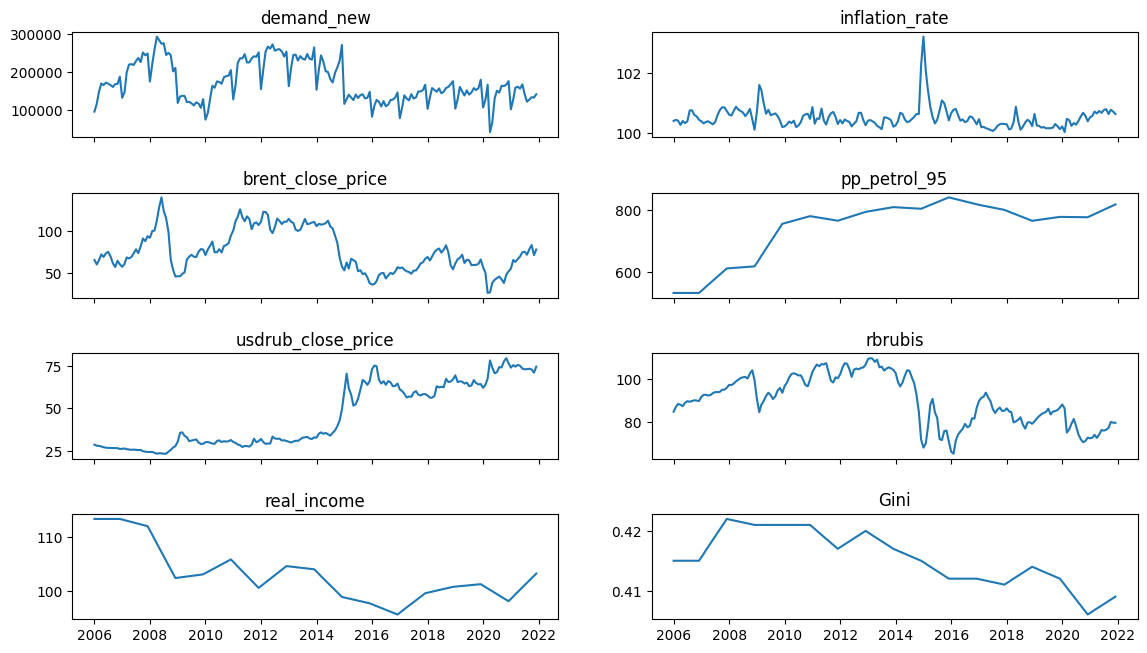

In [521]:
import matplotlib.pyplot as plt
import itertools

columns_to_show = ['demand_new', 'inflation_rate', 'brent_close_price', 'pp_petrol_95',
                   'usdrub_close_price', 'rbrubis', 'real_income', 'Gini']

figure, axis = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(12, 7))
figure.tight_layout(pad=3.)

for ij, col in zip(itertools.product(range(4), range(2)), columns_to_show):
    axis[*ij].plot(all_df.index, all_df[col])
    axis[*ij].set_title(col)

plt.show()

<AxesSubplot: xlabel='date'>

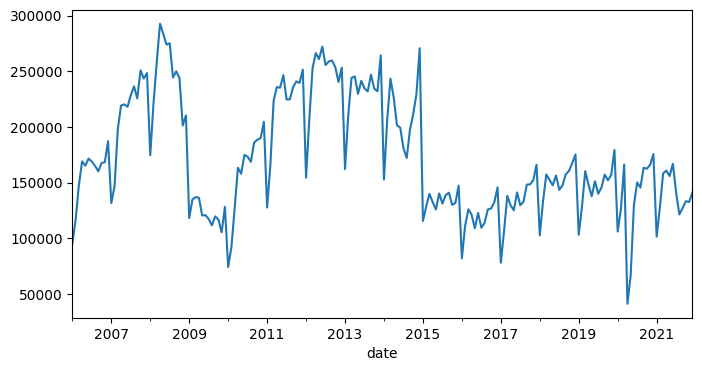

In [522]:
plt.rc('figure', figsize=(8, 4))
all_df['demand_new'].plot()

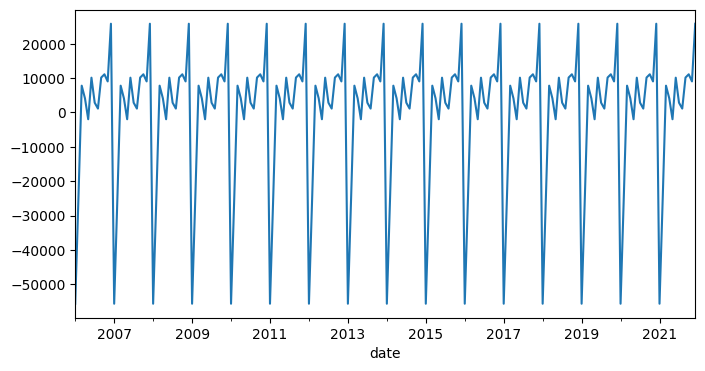

In [523]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(all_df['demand_new'])

all_df['demand_new'] = all_df['demand_new'] - decompose_result.seasonal
all_df = all_df.rename({'demand_new': 'deseasonal_demand_new'}, axis=1)

decompose_result.seasonal.plot()

plt.show()

<AxesSubplot: xlabel='date'>

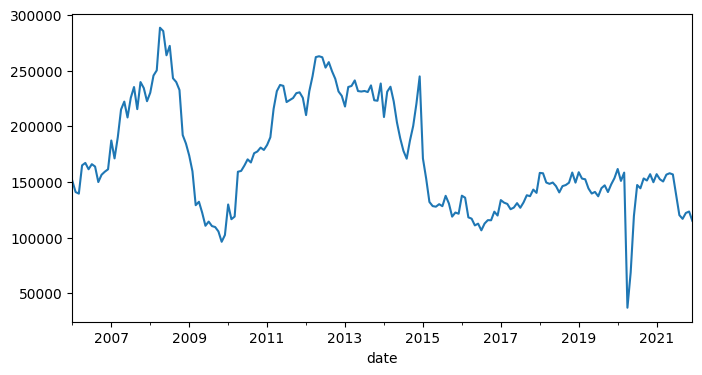

In [524]:
plt.rc('figure', figsize=(8, 4))
all_df['deseasonal_demand_new'].plot()

ADF-test P-value of TS itself: 20.037561%
ADF-test P-value of first differences: 0.000000%


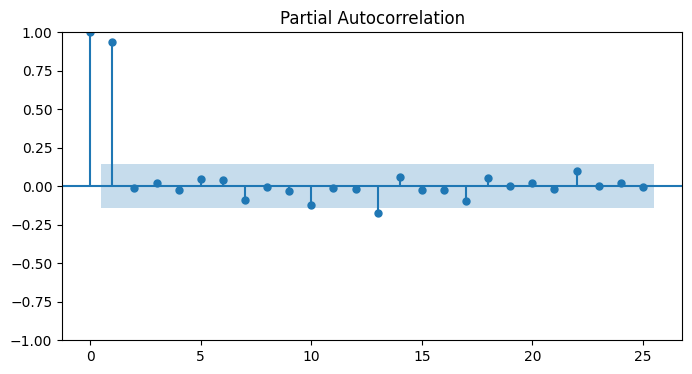

In [525]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

first_diff = all_df['deseasonal_demand_new'].diff(1)[1:]

print(f"ADF-test P-value of TS itself: {adfuller(all_df['deseasonal_demand_new'], autolag='AIC')[1]:%}")
print(f"ADF-test P-value of first differences: {adfuller(first_diff, autolag='AIC')[1]:%}")
# p-value > 0.05 - This implies that time-series is non-stationary.
# p-value <=0.05 - This implies that time-series is stationary.

plot_pacf(all_df['deseasonal_demand_new'], lags=25, method='ywm')

plt.show()

In [527]:
all_df['deseasonal_demand_new'] = all_df['deseasonal_demand_new'].diff(1)
all_df = all_df.rename({'deseasonal_demand_new': 'diff_of_deseasonal_demand_new'}, axis=1)
all_df = all_df[1:]

all_df

,diff_of_deseasonal_demand_new,inflation_rate,brent_close_price,pp_petrol_95,usdrub_close_price,rbrubis,real_income,real_wage,real_pension,Gini
date,,,,,,,,,,
2006-02-01,-9992.594444,100.45,60.05,533.000000,28.1190,87.08,113.466448,113.300000,105.10,0.41500
2006-03-01,-1417.747222,100.42,64.94,533.000000,28.0290,88.40,113.466448,113.300000,105.10,0.41500
2006-04-01,25410.247222,100.28,72.00,533.000000,27.7090,88.03,113.466448,113.300000,105.10,0.41500
2006-05-01,2171.186111,100.41,69.00,533.000000,27.2510,87.34,113.466448,113.300000,105.10,0.41500
2006-06-01,-5679.491667,100.34,73.28,533.000000,26.9900,88.99,113.466448,113.300000,105.10,0.41500
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,-17958.325000,100.80,71.70,804.633333,73.0300,76.33,101.466667,104.266667,103.50,0.40800
2021-09-01,-3329.358333,100.64,78.36,808.075000,73.2445,77.24,101.900000,104.325000,103.65,0.40825
2021-10-01,5274.441667,100.78,83.25,811.516667,72.7945,79.98,102.333333,104.383333,103.80,0.40850


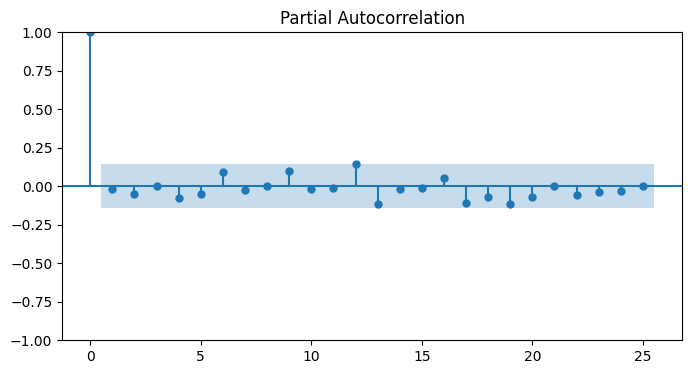

In [529]:
plt.rc('figure', figsize=(8, 4))
plot_pacf(all_df['diff_of_deseasonal_demand_new'], lags=25, method='ywm')

plt.show()

<AxesSubplot: xlabel='date'>

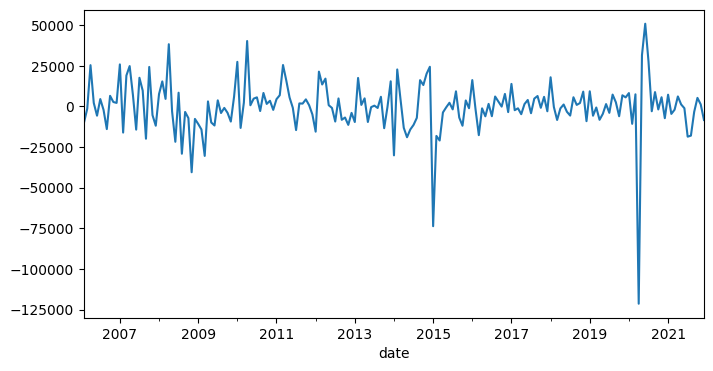

In [530]:
plt.rc('figure', figsize=(8, 4))
all_df['diff_of_deseasonal_demand_new'].plot()

111
['real_wage', 'L7']
110
['inflation_rate', 'L11']
109
['pp_petrol_95', 'L0']
107
['brent_close_price', 'L11']
106
['real_pension', 'L0']
104
['usdrub_close_price', 'L6']
102
['rbrubis', 'L5']
100
['real_pension', 'L3']
99
['inflation_rate', 'L10']
98
['inflation_rate', 'L12']
97
['Gini', 'L6']
96
['real_wage', 'L12']
95
['pp_petrol_95', 'L10']
94
['pp_petrol_95', 'L11']
92
['real_wage', 'L11']
91
['Gini', 'L3']
87
['rbrubis', 'L11']
86
['rbrubis', 'L12']
84
['real_income', 'L2']
81
['usdrub_close_price', 'L12']
80
['real_pension', 'L9']
79
['inflation_rate', 'L4']
77
['real_pension', 'L8']
75
['Gini', 'L8']
74
['usdrub_close_price', 'L3']
72
['usdrub_close_price', 'L0']
71
['usdrub_close_price', 'L8']
68
['real_income', 'L11']
65
['usdrub_close_price', 'L10']
65
['pp_petrol_95', 'L1']
64
['real_pension', 'L5']
62
['inflation_rate', 'L2']
61
['inflation_rate', 'L5']
59
['real_wage', 'L10']
57
['usdrub_close_price', 'L11']
54
['pp_petrol_95', 'L12']
52
['Gini', 'L5']
49
['Gini', 'L4'

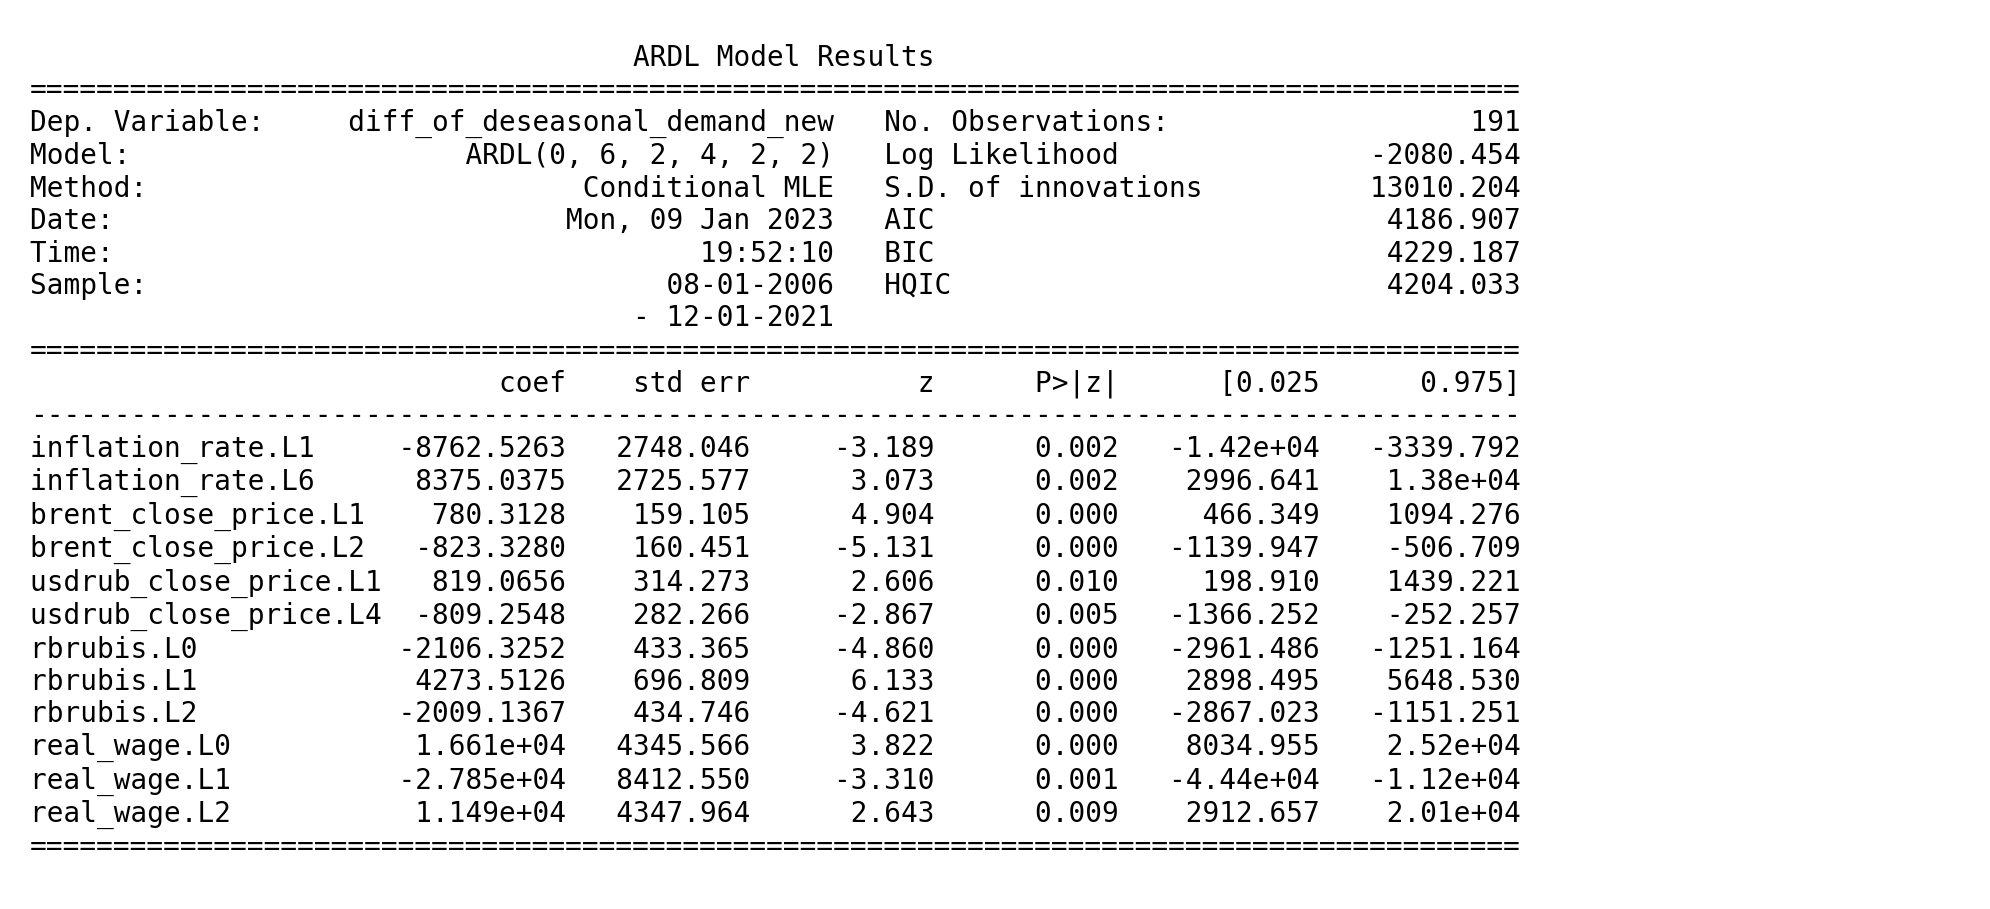

In [653]:
from statsmodels.tsa.api import ARDL
import warnings
warnings.filterwarnings("ignore")

features = ['inflation_rate', 'brent_close_price',
            'pp_petrol_95', 'usdrub_close_price',
            'rbrubis', 'real_income',
            'real_wage', 'real_pension', 'Gini']

lags = {f: [*range(13)] for f in features}

alpha = 0.05
non_significant = True


while non_significant:
    model = ARDL(all_df['diff_of_deseasonal_demand_new'], 0,
               all_df[features], lags,
               trend='n')
    res = model.fit()

    non_significant = [x[0] for x in res.summary().tables[1].data[1:] if float(x[4]) > alpha]

    if non_significant:
        features_lags = [i[0] for i in res.summary().tables[1].data[1:]]
        p_values = [float(i[4]) for i in res.summary().tables[1].data[1:]]

        most_insig = features_lags[p_values.index(max(p_values))].split('.')

        lags[most_insig[0]].remove(int(most_insig[1][1:]))
        for i in lags.keys():
            if not lags[i]:
                lags.pop(i)
                break


plt.rc('figure', figsize=(20, 10))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 20}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.show()
# pd.DataFrame([x for x in res.summary().tables[1].data[1:]],
#              columns = res.summary().tables[1].data[0])